In [1]:
batch_size = 16
content_weight = 0.8

import mpslib
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

training_img = Image.open("xxx.png").convert('1')

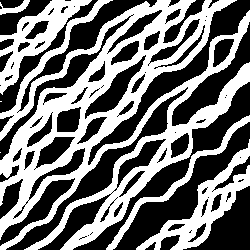

In [2]:
training_img

In [3]:
import utils
import torch
from torchvision import transforms
from Vgg16 import Vgg16
from transformer_net import TransformerNet
from torch.optim import Adam

image_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
])

style = image_transform(training_img)
style = style.repeat(batch_size, 3, 1, 1).to("cuda")
norm_style = utils.normalize_batch(style).to("cuda")

vgg = Vgg16(requires_grad=False).to("cuda")
features_style = vgg(norm_style)
gram_style = [utils.gram_matrix(y) for y in features_style]

transformer =utils.load_model("saved_model_12") # TransformerNet().to("cuda")


In [4]:
mse_loss = torch.nn.MSELoss()

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import time


transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((92,92)),
        transforms.CenterCrop((92,92)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder("ex",transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [5]:
hard_data = np.loadtxt("hard_as_hard_120.dat", skiprows=7, usecols=[0, 1, 3]).swapaxes(0,1).astype(int)

In [6]:
    optimizer = Adam(transformer.parameters(), 0.005)
    hard_x = hard_data[0,:]
    hard_y = hard_data[1,:]
    hard_mask = np.zeros((92,92))
    hard_mask[hard_x, hard_y] = 1
    hard_mask = torch.from_numpy(hard_mask).to("cuda")
    for e in range(500):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        agg_hard_loss = 0.0
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()


            x = x.to('cuda')
            y = transformer(x)

            features_y = vgg(utils.normalize_batch(y.repeat(1, 3, 1, 1)))
            features_x = vgg(utils.normalize_batch(x.repeat(1,3,1,1)))

            content_loss = mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0. 
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= 2*255
            #hard_loss = mse_loss(x*hard_mask, y*hard_mask)

            total_loss = content_loss + style_loss# + hard_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()
            #agg_hard_loss += hard_loss.item()

            if (batch_id + 1) % 10 == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\t hard: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  agg_hard_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss + agg_hard_loss) / (batch_id + 1)
                )
                print(mesg)
        print("saving model")
        torch.save(transformer.state_dict(), "saved_model_12")

010	style: 12.047490	 hard: 0.000000	total: 12.617500
Sun May  2 22:30:40 2021	Epoch 23:	[14880/20000]	content: 0.569996	style: 12.047538	 hard: 0.000000	total: 12.617534
Sun May  2 22:30:41 2021	Epoch 23:	[15040/20000]	content: 0.570008	style: 12.047497	 hard: 0.000000	total: 12.617505
Sun May  2 22:30:42 2021	Epoch 23:	[15200/20000]	content: 0.569999	style: 12.047597	 hard: 0.000000	total: 12.617596
Sun May  2 22:30:44 2021	Epoch 23:	[15360/20000]	content: 0.570012	style: 12.047576	 hard: 0.000000	total: 12.617588
Sun May  2 22:30:45 2021	Epoch 23:	[15520/20000]	content: 0.570038	style: 12.047420	 hard: 0.000000	total: 12.617458
Sun May  2 22:30:46 2021	Epoch 23:	[15680/20000]	content: 0.570041	style: 12.047283	 hard: 0.000000	total: 12.617324
Sun May  2 22:30:47 2021	Epoch 23:	[15840/20000]	content: 0.570022	style: 12.047253	 hard: 0.000000	total: 12.617274
Sun May  2 22:30:48 2021	Epoch 23:	[16000/20000]	content: 0.569993	style: 12.047370	 hard: 0.000000	total: 12.617363
Sun May  2

KeyboardInterrupt: 

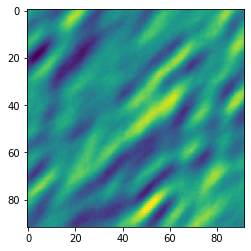

In [16]:
out = y
plt.imshow(out[0].cpu().detach().clone().clamp(0, 255).numpy()[0,:,:])